https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes

# Title: Price Prediction for used Cars

## Brief Summary:
- Price prediction of used cars for 8 makes and 196 car models. 100k car listings and 9 features.
- Trained Linear Regression, Lasso and Ridge with Polynomial Features selected with SelectKBest produced an R2 score of 0.873.
- The best R2 score of 0.867 achieved by training LGBM for each car model.


## Description
The goal fo this project is to predict the price of a car based on 9 features. The dataset has a very limited number of features and is missing key information around car trim, ownership type, accident history.

## Dataset
- this is a public Dataset availagle on [Kaggle](https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes)
- the combined dataset contains 100k listings of car from UK and includes 8 makes and 196 models with diesel, pertrol and hybrid fuel types.
- available features: 'make', 'model', 'year', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg', and 'engineSize' with regression target 'price'.

## EDA
- each make contains between 4711 (Hyundi) and 17751 (Ford) listings.
- across all makes, there are 132 models that have less than 10 listings.
- the dataset contains 1475 duplicates, the 'tax' column for hyundi had a different name
- There are no missing values
- mpg has many invalid values, especially around hybrids and electric vehicles

## Transformations:
- Unify the 'tax' column within makes
- Drop 1475 duplicates
- Strip whitespaces from model names
- drop 9 listings with 'transmission' = 'Other'
- drop 252 listings with 'fuelType' = 'Other' or 'Electric'
- drop 265 listings with 'engineSize'] = 0
- drop cars produced before 1990 and with invalid production year > 2022

## Feature Engineering:
- the limited number of features in this dataset does not provide the oportunity for extensive feature engineering
- I've created the 'car' feture that represents a combined make and model
- the Year column was change to age
- price was caled to values form 1 to 100
- I've used Ordinal Encoding for fuelType and transmission
- Training one model for all 196 unique car types will require creating 196 one-hot encoded features. For this dataset I've decided to select few cars (make-model combination) and create models individually 

# Cross Validation
- I've used RepeatedKFold with 6 splits and 3 repeats to shortlist the models and narrow down hyperparameters, and later increase the splits to 8 and repeats to 10.

# Linear Models:
 - I've utilized the PolynomialFeatures to create new feature matrix with 2 to 5 degrees
 - new features were scaled without mean and passed to SelectKBest to select up to 100 best features
 - Evaluated models:
 - LinearRegression, 
 - Lasso and Ridge with alpha [0.3, 0.6, 0.9]
 
<!-- # Defining the goal:
In order to define the price variance within similar cars I've groupped the cars by 'make', 'model', 'year', 'transmission', 'fuelType', 'engineSize' and mileage rounded to the nearest 5k miles.
The std in the groupped cars is 1322.47, and price MAD is 482.18.
I will use the variance in ground truth to evaluate the MAE and RMSE values in model performance. -->

# Setup and Imports

In [1]:
import sys
if '../Toolkit' not in sys.path: sys.path.append('../Toolkit')

%load_ext autoreload
%autoreload 1

%aimport tools
%aimport models

import tools as t
import models as m

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.display import clear_output

import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 113
import matplotlib.pyplot as plt
import seaborn as sns

RS = 35577 # global random state seed
raw_data_path = 'data-raw'
processed_data_path = 'data-processed'

In [2]:
from pathlib import Path

# Select and Merge CSV's

In [3]:
csv_paths = [f for f in Path(f'{raw_data_path}').iterdir()]
csv_paths

[PosixPath('data-raw/audi.csv'),
 PosixPath('data-raw/bmw.csv'),
 PosixPath('data-raw/ford.csv'),
 PosixPath('data-raw/hyundi.csv'),
 PosixPath('data-raw/merc.csv'),
 PosixPath('data-raw/skoda.csv'),
 PosixPath('data-raw/toyota.csv'),
 PosixPath('data-raw/vauxhall.csv'),
 PosixPath('data-raw/vw.csv')]

In [4]:
all_series = []
for c_p in csv_paths:
    df = pd.read_csv(c_p)
    s = (~df.isna()).sum()
    s.name = c_p.name
    all_series.append(s)
    
df_all_desc = pd.concat(all_series, axis=1).fillna(0)
df_all_desc.style.background_gradient(cmap = 'Greens', vmin=-1000).format('{:.0f}')

df_all_desc.columns

,audi.csv,bmw.csv,ford.csv,hyundi.csv,merc.csv,skoda.csv,toyota.csv,vauxhall.csv,vw.csv
model,10668,10781,17965,4860,13119,6267,6738,13632,15157
year,10668,10781,17965,4860,13119,6267,6738,13632,15157
price,10668,10781,17965,4860,13119,6267,6738,13632,15157
transmission,10668,10781,17965,4860,13119,6267,6738,13632,15157
mileage,10668,10781,17965,4860,13119,6267,6738,13632,15157
fuelType,10668,10781,17965,4860,13119,6267,6738,13632,15157
tax,10668,10781,17965,0,13119,6267,6738,13632,15157
mpg,10668,10781,17965,4860,13119,6267,6738,13632,15157
engineSize,10668,10781,17965,4860,13119,6267,6738,13632,15157
tax(£),0,0,0,4860,0,0,0,0,0


Index(['audi.csv', 'bmw.csv', 'ford.csv', 'hyundi.csv', 'merc.csv',
       'skoda.csv', 'toyota.csv', 'vauxhall.csv', 'vw.csv'],
      dtype='object')

In [5]:
csv_names = ['audi.csv', 'bmw.csv', 'ford.csv', 'hyundi.csv', 'merc.csv', 'skoda.csv', 'toyota.csv', 'vauxhall.csv', 'vw.csv']

all_dfs = []
for csv_name in csv_names:
    df_path = f'{raw_data_path}/{csv_name}'
    df = pd.read_csv(f'{raw_data_path}/{csv_name}')
    if 'tax(£)' in df.columns:
        df.rename(columns={"tax(£)": "tax"}, inplace=True)
    df.insert(0, 'make', csv_name[:-4].title())
    all_dfs.append(df)
    
df_data = pd.concat(all_dfs, axis=0, ignore_index=True)


# Preliminary analysis

In [6]:
'df has duplives: ', df_data.duplicated().sum()

('df has duplives: ', 1475)

In [7]:
df_data.info()
df_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99187 entries, 0 to 99186
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   make          99187 non-null  object 
 1   model         99187 non-null  object 
 2   year          99187 non-null  int64  
 3   price         99187 non-null  int64  
 4   transmission  99187 non-null  object 
 5   mileage       99187 non-null  int64  
 6   fuelType      99187 non-null  object 
 7   tax           99187 non-null  int64  
 8   mpg           99187 non-null  float64
 9   engineSize    99187 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 7.6+ MB


,year,price,mileage,tax,mpg,engineSize
count,99187.000000,99187.000000,99187.000000,99187.000000,99187.000000,99187.000000
mean,2017.087723,16805.347656,23058.914213,120.299838,55.166825,1.663280
std,2.123934,9866.773417,21148.523721,63.150926,16.138522,0.557646
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,9999.000000,7425.000000,125.000000,47.100000,1.200000
50%,2017.000000,14495.000000,17460.000000,145.000000,54.300000,1.600000
75%,2019.000000,20870.000000,32339.000000,145.000000,62.800000,2.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


In [8]:
df_data.columns

cat_features = ['make', 'model', 'transmission', 'fuelType']
'cat_features', cat_features

num_features = ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']
'num_features', num_features

len(cat_features + num_features) == len(df.columns)

Index(['make', 'model', 'year', 'price', 'transmission', 'mileage', 'fuelType',
       'tax', 'mpg', 'engineSize'],
      dtype='object')

('cat_features', ['make', 'model', 'transmission', 'fuelType'])

('num_features', ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize'])

True

### Remove whitespaces from model

In [9]:
df_data['model'] = df_data['model'].str.strip()
df_data.drop_duplicates(inplace=True)
df_data.duplicated().sum()

0

# Transformations

In [10]:
df_data.drop_duplicates(inplace=True)
df_data['model'] = df_data['model'].str.strip()

drop_cars_transmission_other = lambda df: df.drop(df.loc[df['transmission'] =='Other'].index)
drop_other_electric_fuel_types = lambda df: df.drop(df.loc[df['fuelType'].isin(['Other', 'Electric'])].index)
drop_bmw_i3 = lambda df: df.drop(df.loc[df['model'] == 'i3'].index)
drop_engine_size_0 = lambda df: df.drop(df.loc[df['engineSize'] == 0].index)
drop_cars_older_1990_and_from_future = lambda df : df.drop(df.loc[ (df['year'] < 1990) | (2022 < df['year']) ].index)

drop_mpg_tax = lambda df: df.drop(columns=['mpg', 'tax'])

# Visualise the Data

## Categorical Features

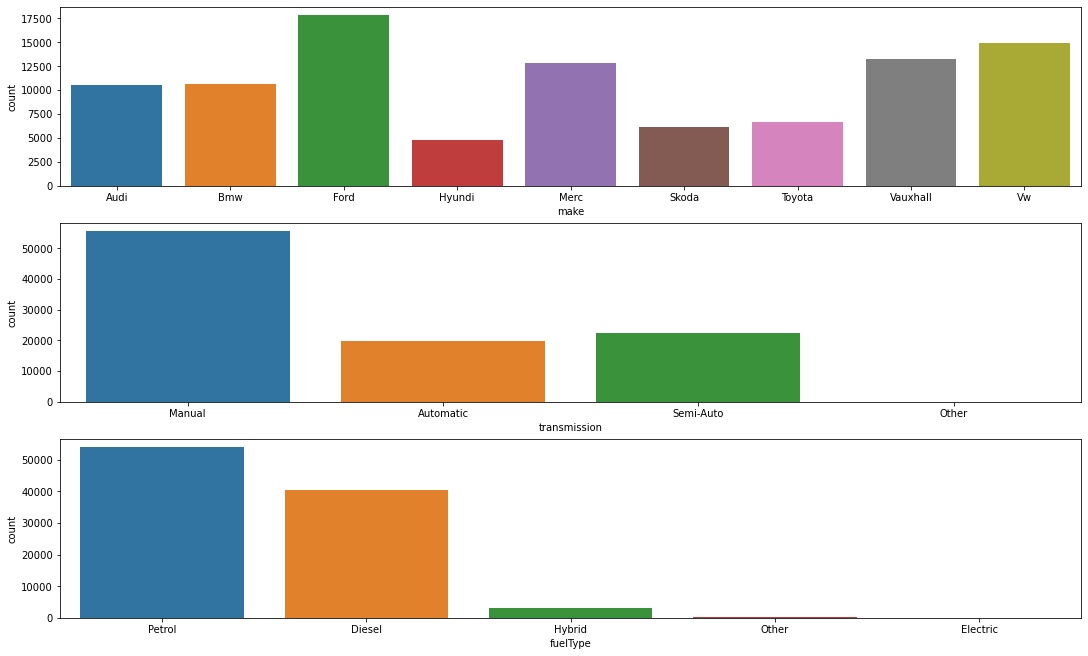

In [11]:
axs = t.get_axes(3, 1, 0.2)
for col, ax in zip(['make', 'transmission', 'fuelType'], axs.flat):
    _ = sns.countplot(ax=ax, data=df_data, x=col)

In [38]:
df_data['make'].value_counts()

Ford        17751
Vw          14763
Vauxhall    13205
Merc        12826
Bmw         10565
Audi        10487
Toyota       6572
Skoda        6173
Hyundi       4711
Name: make, dtype: int64

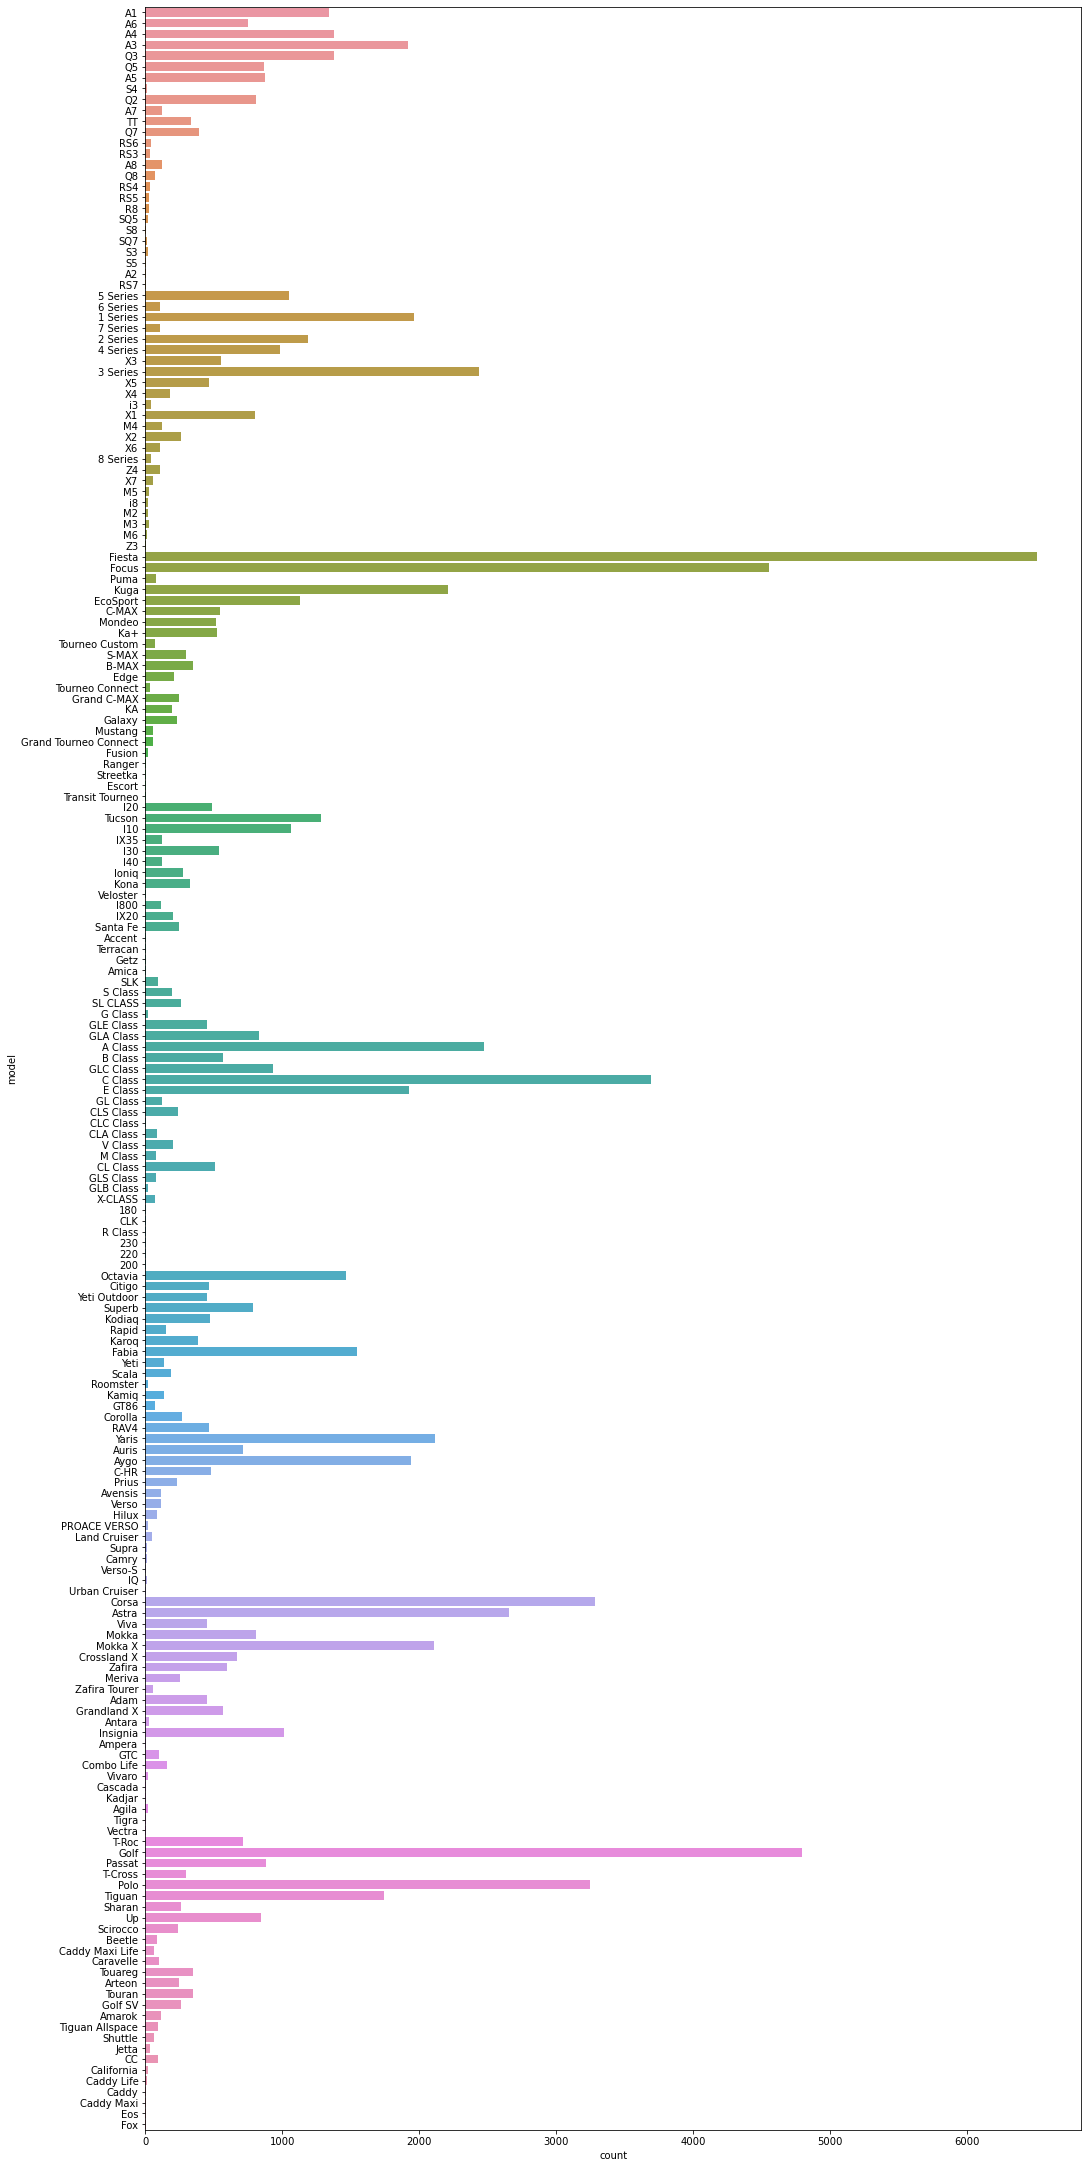

In [12]:
ax = t.get_ax(2)
_ = sns.countplot(ax=ax, data=df_data, y='model')

In [13]:
df_transmission_other = df_data.loc[df_data['transmission'] =='Other']
len(df_transmission_other)
df_transmission_other

9

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
44153,Hyundi,Ioniq,2017,12495,Other,27779,Hybrid,0,78.5,1.6
44175,Hyundi,Tucson,2017,16995,Other,25915,Petrol,145,39.8,1.6
53924,Merc,GLA Class,2016,18700,Other,30895,Other,125,56.5,0.0
57036,Merc,SLK,2015,12995,Other,39000,Diesel,150,56.5,2.1
63519,Skoda,Scala,2019,15999,Other,3500,Petrol,145,47.1,1.0
66118,Toyota,Yaris,2015,12795,Other,16733,Hybrid,0,78.0,1.5
77102,Vauxhall,Mokka,2019,19995,Other,1450,Diesel,145,57.7,1.5
77717,Vauxhall,Mokka,2019,13499,Other,3000,Petrol,145,44.8,1.4
77820,Vauxhall,Mokka,2019,22499,Other,4500,Petrol,145,42.2,1.5


In [14]:
df_fule_type_other = df_data.loc[df_data['fuelType'] == 'Other']
len(df_fule_type_other)
df_fule_type_other.head(5)

246

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
10684,Bmw,3 Series,2017,14250,Automatic,55594,Other,135,148.7,2.0
10700,Bmw,i3,2016,17100,Automatic,25269,Other,0,470.8,0.6
10703,Bmw,2 Series,2017,13000,Automatic,61818,Other,0,141.2,1.5
10754,Bmw,2 Series,2017,16000,Automatic,32389,Other,0,141.2,1.5
10786,Bmw,X5,2016,21000,Automatic,71626,Other,0,85.6,2.0


In [15]:
df_fule_type_electric = df_data.loc[df_data['fuelType'] == 'Electric']
len(df_fule_type_electric)
df_fule_type_electric.head(5)

6

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
19043,Bmw,i3,2017,18999,Automatic,20321,Electric,135,470.8,0.0
19068,Bmw,i3,2016,18999,Automatic,9990,Electric,0,470.8,0.0
19503,Bmw,i3,2015,17400,Automatic,29465,Electric,0,470.8,1.0
27834,Ford,Mondeo,2016,15975,Automatic,9396,Electric,0,67.3,2.0
33408,Ford,Mondeo,2016,15500,Automatic,24531,Electric,0,67.3,2.0


In [16]:
df_data = drop_other_electric_fuel_types(df_data)
df_data = drop_cars_transmission_other(df_data)

## Numeric - Discreet

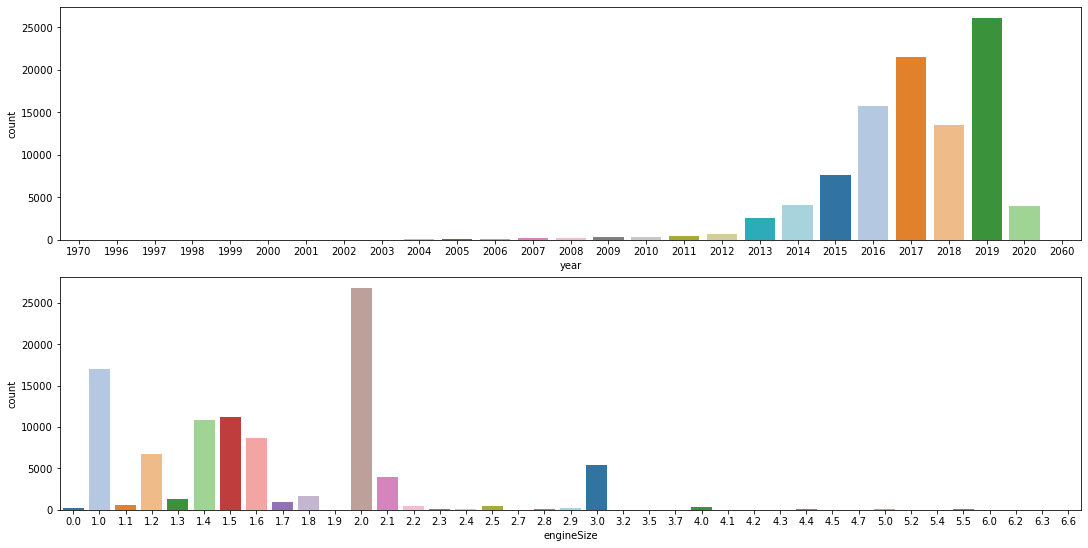

In [17]:
axs = t.get_axes(2, 1, 0.25).flat
_ = sns.countplot(ax=axs[0], x = df_data.year, palette=plt.cm.tab20.colors)

_ = sns.countplot(ax=axs[1], x = df_data.engineSize, palette=plt.cm.tab20.colors)

In [18]:
df_engineSize_0 = df_data.loc[df_data['engineSize'] == 0]
len(df_engineSize_0)
df_engineSize_0['model'].value_counts(normalize=True)

265

i3           0.124528
Q3           0.086792
Fiesta       0.071698
I10          0.064151
Astra        0.052830
Focus        0.041509
Tucson       0.037736
I20          0.030189
EcoSport     0.030189
A3           0.026415
Insignia     0.026415
Corsa        0.022642
A Class      0.022642
KA           0.022642
1 Series     0.018868
Q2           0.018868
Q5           0.018868
Ka+          0.015094
I30          0.015094
3 Series     0.015094
Passat       0.015094
Octavia      0.011321
I800         0.011321
Golf         0.011321
Tiguan       0.011321
Aygo         0.011321
IX35         0.011321
S4           0.011321
A5           0.011321
Up           0.007547
SQ5          0.007547
T-Roc        0.007547
Ampera       0.007547
Fabia        0.007547
Yaris        0.007547
2 Series     0.007547
TT           0.007547
I40          0.003774
Mokka        0.003774
A4           0.003774
Adam         0.003774
Meriva       0.003774
Zafira       0.003774
C-HR         0.003774
A1           0.003774
Puma      

In [19]:
df_bmw_i3 = df_data.loc[df_data['model'] == 'i3']
len(df_bmw_i3)
df_bmw_i3.head()

33

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
11289,Bmw,i3,2017,19998,Automatic,41949,Hybrid,140,470.8,0.0
11446,Bmw,i3,2017,19998,Automatic,41146,Hybrid,0,470.8,0.0
11448,Bmw,i3,2017,21898,Automatic,10839,Hybrid,0,470.8,0.0
12534,Bmw,i3,2017,19980,Automatic,26965,Hybrid,140,470.8,0.0
13020,Bmw,i3,2016,19490,Automatic,8421,Hybrid,0,470.8,0.0


In [20]:
df_data = drop_bmw_i3(df_data)
df_data = drop_engine_size_0(df_data)

## Numeric - Continuous

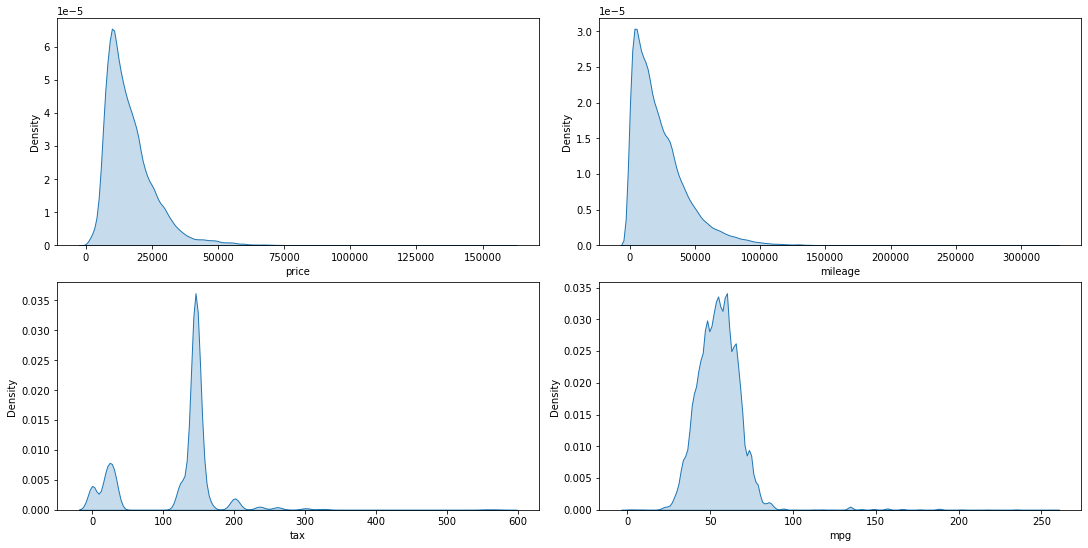

In [21]:
axs = t.get_axes(2, 2, 0.5)

for col, ax in zip(['price', 'mileage', 'tax', 'mpg'], axs.flat):
    _ = sns.kdeplot(ax=ax, data=df_data, x=col, shade=True)

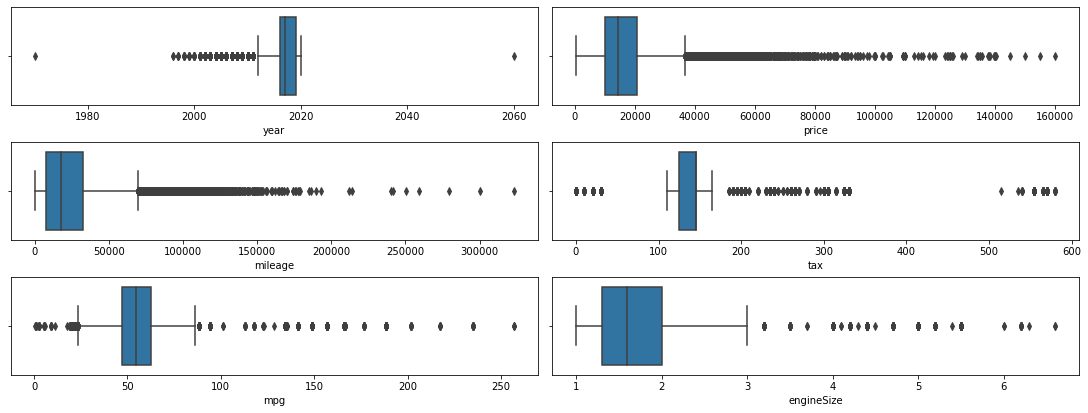

In [22]:
axs = t.get_axes(3, 2, 0.25)

for col, ax in zip(num_features, axs.flat):
    _ = sns.boxplot(ax=ax, x=df_data[col], orient='w')
    # ax.axes.get_yaxis().set_visible(False)

In [23]:
df_data.sort_values(by=['year']).head(5)
df_data.sort_values(by=['year']).tail(5)

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
81235,Vauxhall,Zafira,1970,10495,Manual,37357,Petrol,200,42.2,1.4
20293,Bmw,5 Series,1996,5995,Automatic,36000,Petrol,270,26.4,2.8
38327,Ford,Escort,1996,3000,Manual,50000,Petrol,265,34.4,1.8
76255,Vauxhall,Astra,1997,950,Manual,89233,Petrol,265,35.8,1.6
10427,Audi,A8,1997,4650,Automatic,122000,Petrol,265,18.9,4.2


,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
74902,Vauxhall,Astra,2020,15690,Manual,298,Petrol,145,54.3,1.2
74900,Vauxhall,Astra,2020,15990,Manual,397,Petrol,145,54.3,1.2
50682,Merc,E Class,2020,42990,Semi-Auto,3541,Petrol,145,32.9,2.0
33747,Ford,EcoSport,2020,19000,Manual,10,Petrol,145,52.3,1.0
39175,Ford,Fiesta,2060,6495,Automatic,54807,Petrol,205,42.8,1.4


In [24]:
df_data = drop_cars_older_1990_and_from_future(df_data)

In [25]:
df_data.sort_values(by=['price']).head(5)
df_data.sort_values(by=['price']).tail(5)

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
76318,Vauxhall,Astra,2001,450,Manual,159000,Petrol,235,40.4,1.6
84017,Vauxhall,Agila,2003,450,Manual,90000,Petrol,205,43.5,1.2
73656,Vauxhall,Corsa,2002,495,Manual,99842,Petrol,145,50.4,1.0
38552,Ford,Focus,2003,495,Manual,177644,Petrol,200,41.5,1.6
73670,Vauxhall,Corsa,2003,590,Manual,82000,Petrol,160,44.8,1.2


,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
53011,Merc,A Class,2019,140319,Semi-Auto,785,Petrol,150,22.1,4.0
4783,Audi,R8,2020,145000,Semi-Auto,2000,Petrol,145,21.1,5.2
44279,Merc,SL CLASS,2011,149948,Automatic,3000,Petrol,570,21.4,6.2
54318,Merc,G Class,2020,154998,Automatic,3000,Petrol,150,21.4,4.0
50473,Merc,G Class,2020,159999,Semi-Auto,1350,Petrol,145,21.4,4.0


In [26]:
df_data.sort_values(by=['mileage']).head(5)
df_data.sort_values(by=['mileage']).tail(5)

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
92150,Vw,Polo,2020,16990,Manual,1,Petrol,150,50.4,1.0
28379,Ford,Fiesta,2017,10995,Manual,1,Petrol,145,65.7,1.0
42109,Hyundi,I30,2019,27800,Manual,1,Petrol,145,34.0,2.0
97353,Vw,Beetle,2001,899,Automatic,1,Petrol,325,29.7,2.0
82470,Vauxhall,Grandland X,2019,24995,Manual,1,Petrol,145,44.1,1.2


,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
62978,Skoda,Octavia,2010,1485,Manual,250650,Diesel,125,57.6,1.9
55618,Merc,V Class,2010,6949,Automatic,259000,Diesel,540,30.7,3.0
81217,Vauxhall,Zafira,2013,1395,Manual,279000,Diesel,150,55.4,1.7
63462,Skoda,Octavia,2010,1190,Manual,300000,Diesel,125,57.6,1.9
9822,Audi,A6,2008,2490,Manual,323000,Diesel,200,44.1,2.0


In [27]:
df_data.sort_values(by=['mpg']).head(5)
df_data.sort_values(by=['mpg']).tail(5)

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
98534,Vw,Golf SV,2019,17950,Manual,100,Petrol,145,0.3,1.0
40222,Hyundi,Ioniq,2020,23895,Automatic,4152,Hybrid,135,1.1,1.6
54640,Merc,A Class,2020,33900,Automatic,345,Hybrid,140,1.1,1.3
39624,Hyundi,Ioniq,2019,22998,Automatic,2844,Hybrid,140,1.1,1.6
44220,Hyundi,Ioniq,2020,28995,Automatic,5213,Hybrid,135,1.1,1.6


,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
69778,Toyota,Prius,2019,24987,Automatic,6552,Hybrid,135,235.0,1.8
69927,Toyota,Prius,2018,19699,Automatic,43678,Hybrid,135,235.0,1.8
41629,Hyundi,Ioniq,2018,18999,Automatic,12045,Hybrid,135,256.8,1.6
41502,Hyundi,Ioniq,2019,19995,Automatic,7386,Hybrid,135,256.8,1.6
40627,Hyundi,Ioniq,2018,18970,Automatic,14886,Hybrid,135,256.8,1.6


In [28]:
df_data = drop_mpg_tax(df_data)

## Pairplot

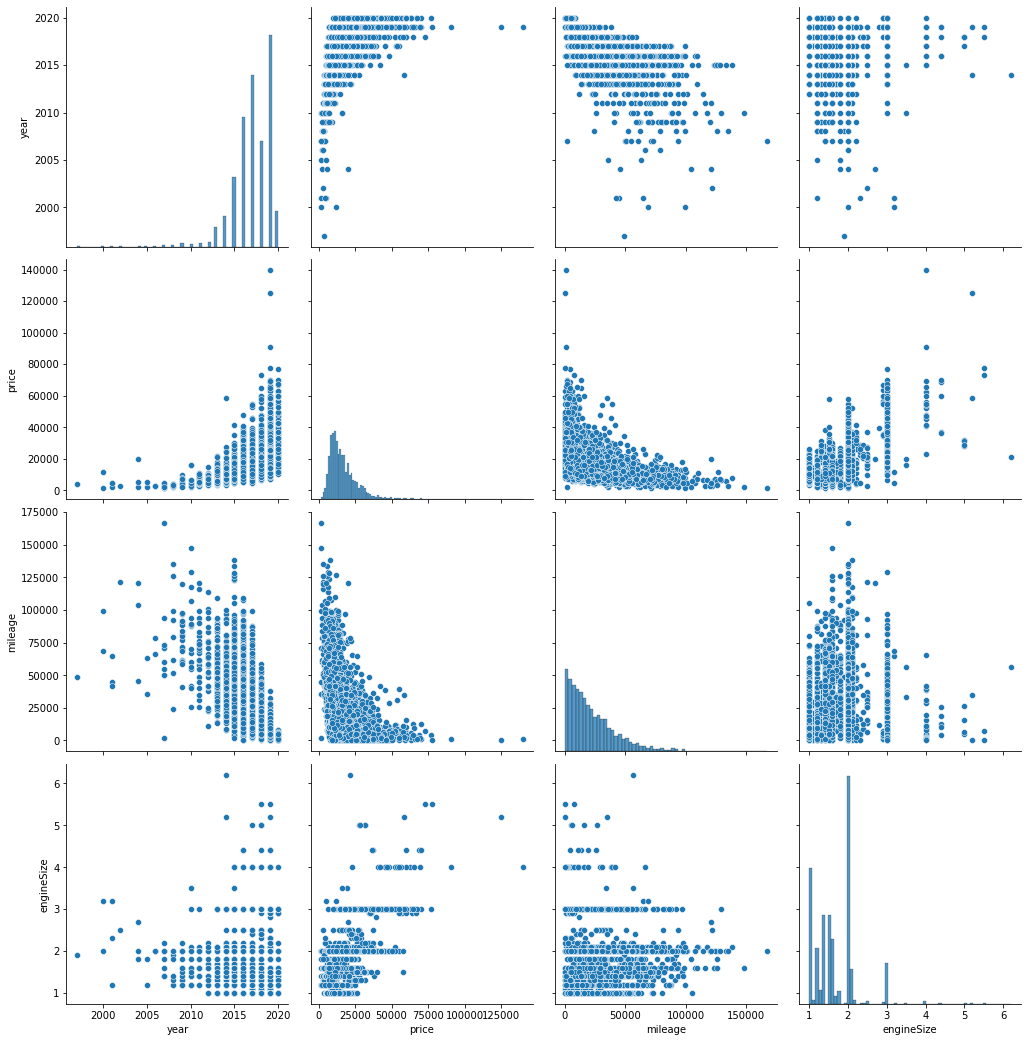

In [29]:
df_plt = df_data.sample(5000, random_state=RS)
_ = sns.pairplot(data=df_plt).fig.set_size_inches(15,15)

## model occurance analysis

In [30]:
car_vc = (df_data['make'] + '__' + df_data['model']).value_counts().sort_values()
car_vc[car_vc <10]
car_vc[car_vc <10].sum()

Audi__RS7                1
Hyundi__Accent           1
Hyundi__Amica            1
Merc__180                1
Ford__Transit Tourneo    1
Audi__A2                 1
Merc__220                1
Merc__200                1
Ford__Escort             1
Ford__Ranger             1
Ford__Streetka           2
Merc__R Class            2
Hyundi__Terracan         2
Hyundi__Veloster         3
Merc__CLC Class          3
Audi__S5                 3
Toyota__Verso-S          3
Vauxhall__Kadjar         3
Vauxhall__Tigra          3
Audi__S8                 4
Toyota__Urban Cruiser    4
Vauxhall__Cascada        4
Vauxhall__Vectra         4
Vw__Fox                  4
Vw__Caddy Maxi           4
Hyundi__Getz             6
Vw__Caddy                6
Merc__CLK                7
Bmw__Z3                  7
Vw__Eos                  7
Audi__SQ7                8
Toyota__IQ               8
Bmw__M6                  8
Vw__Caddy Life           8
Audi__S4                 9
dtype: int64

132

In [31]:
drop_cars_by_name = lambda df, names: df.drop( df.loc[ (df['make'] + '__' + df['model']).isin(names) ].index )

df_data.shape
df_data = drop_cars_by_name(df_data, car_vc[car_vc <10].index.to_list())

(97185, 8)

## Price analysis

In [32]:
mileage_5k = ((df_data['mileage'] / 5000).round(0) * 5000).astype(int)

df_grp = df_data.drop(columns='mileage').groupby(['make', 'model', 'year', 'transmission', mileage_5k, 'fuelType', 'engineSize'])\
    ['price'].agg([len, np.mean, np.std, m.mad])

4.07665812576133

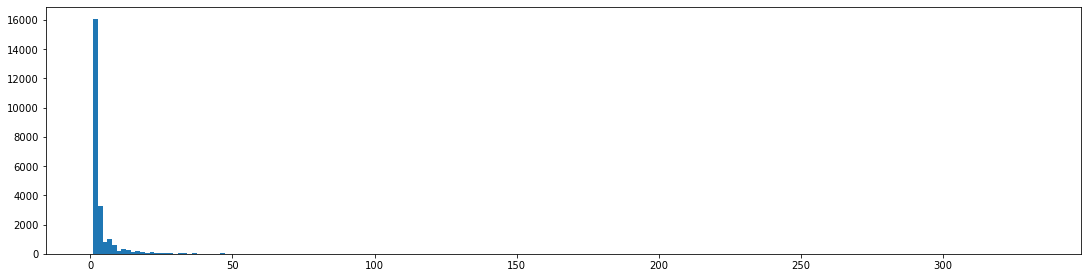

In [33]:
ax = t.get_ax(0.25)
_ = ax.hist(df_grp['len'], bins=200)

df_grp['len'].mean()

In [34]:
df_grp['std'].mean()
df_grp['mad'].mean()

1322.468574588338

482.1781696748918

In [35]:
df_grp['std'].describe()
df_grp['mad'].describe()

count    11654.000000
mean      1322.468575
std       1421.556426
min          0.000000
25%        528.889993
50%        956.013675
75%       1650.776952
max      42744.604923
Name: std, dtype: float64

count    23807.000000
mean       482.178170
std        884.246631
min          0.000000
25%          0.000000
50%          0.000000
75%        696.543333
max      30225.000000
Name: mad, dtype: float64

In [39]:
t.to_pkl(df_data, f'{processed_data_path}/df_clean.pkl')